# THE BATTLE OF NEIGHBORHOODS

## Introduction:

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016, demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items.There are many resturants in Toronto, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of Toronto that has great indian resturants.

## Data:

For this project we need the following data:

 * Toronto data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
 * Indian resturants in each neighborhood of new york city.


## Questions that will be answers at the end of this project :

 1. Which the major part of Toronto that has more Indian restaurant?
 2. What is best location in Toronto for Indian cuisine?
 3. Which area lacks Indian restaurant? 


## Methodology:

 * We begin by collecting the Toronto data from "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M".
   and we will collect latitude and longitude Data from "http://cocl.us/Geospatial_data" and combine them 
 * We will find all venues for each neighborhood using FourSquare API.
 * We will then filter out all Indian Restuarant venues.
 * Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
 * Next we will sort the data keeping Ratings as the constraint.
 * Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

In [12]:
!conda install -c conda-forge geopy --yes #for geo. Add
!conda install -c conda-forge folium=0.5.0 --yes #For Map
!conda install -c anaconda beautifulsoup4 --yes #bs4
!conda install -c anaconda lxml --yes
from geopy.geocoders import Nominatim
import folium # map rendering library

import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
from bs4 import BeautifulSoup 
import xml

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               anaconda::certifi-2020.4.5.1-py36_0 --> conda-forge::certifi-2020.4.5.1-py36h9f0ad1d_0
  openssl               anaconda::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    con

### Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [14]:
 def geo_location(address):# get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [100]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID     = '**********************' # your Foursquare ID
    CLIENT_SECRET = '**********************' # your Foursquare Secret
    VERSION = '20200513' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names) # Create dataframe 
    return df

### Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [99]:
def get_venue_details(venue_id):
        
    CLIENT_ID     = '**********************' # your Foursquare ID
    CLIENT_SECRET = '**********************' # your Foursquare Secret
    VERSION = '20200513' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [17]:
def Toronto_get_data():
    url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
    soup = BeautifulSoup(url,features="lxml")
    table_post = soup.find('table')
    fields = table_post.find_all('td')

    postcode = []
    borough = []
    neighbourhood = []

    for i in range(0, len(fields), 3):
        postcode.append(fields[i].text.strip())
        borough.append(fields[i+1].text.strip())
        neighbourhood.append(fields[i+2].text.strip())
        
    df = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()
    df.columns = ['Postcode', 'Borough', 'Neighbourhood']
    # Removing "Not assigned" Borough
    df['Borough'].replace('Not assigned', np.nan, inplace=True)
    df_N=df.dropna(subset=['Borough']).reset_index()
    df_N.drop(columns=['index'],inplace=True)
    # Reading Lat. Long.
    df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
    df_geo.columns = ['Postcode', 'Latitude', 'Longitude']
    df_Res = pd.merge(df_N, df_geo, on='Postcode')
    
    return df_Res

### Check our data 

In [28]:
Toronto_data = Toronto_get_data()
Toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [27]:
Toronto_data.shape

(103, 5)

The above result shows that there are 103 different Neighborhoods in Toronto.

### Now let create a BAR PLOT to show different Neighborhoods in Toronto.

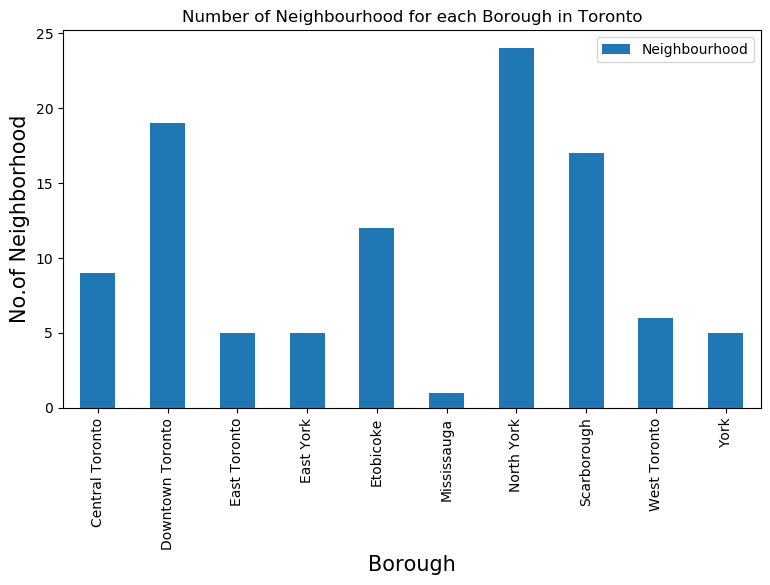

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
Toronto_data.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()
plt.savefig('No_Of_Br_in_tr.png') # save plot as image 

From the above Bar Plot, we can see that North York has highest number of neighborhoods

### Next we will collect Indian resturants for each Neighborhood

In [140]:
column_names=['Postcode','Borough', 'Neighbourhood', 'ID','Name']
indian_rest_Tr=pd.DataFrame(columns=column_names)
count=1
for row in Toronto_data.values.tolist():
    Postcode, Borough, Neighbourhood, Latitude, Longitude =row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_Tr = indian_rest_Tr.append({'Postcode' : Postcode,
                                                'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [218]:
    indian_rest_Tr.shape

(45, 5)

 From the above result, we see that there are 45 Indian Resturants across Toronto

### Now let create a BAR PLOT to show Number of Indian Resturants for each Borough in Toronto.

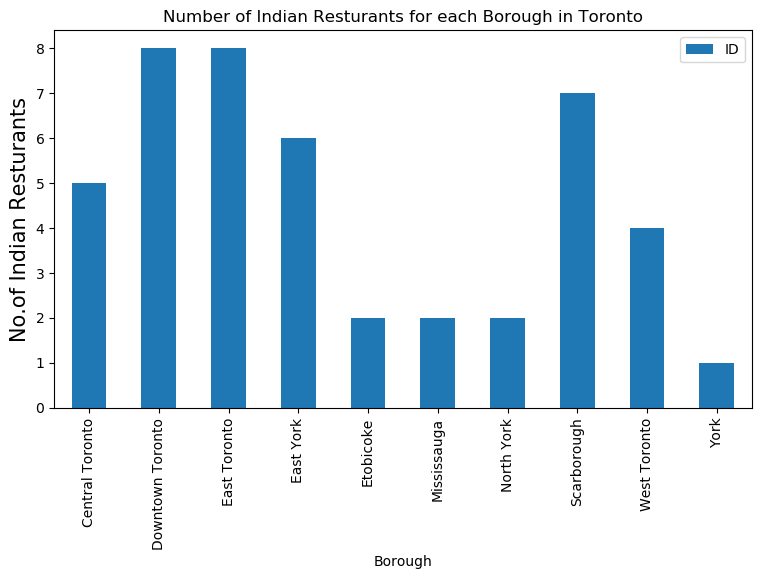

In [224]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 10)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_Tr.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.savefig('No_Of_Indian_Res_in_tr.png',pad_inches=0) # save plot as image 
plt.show()


From the above Bar Plot, we can see that "Downtown Toronto" and "East Toronto" has highest number of Indian resturants.

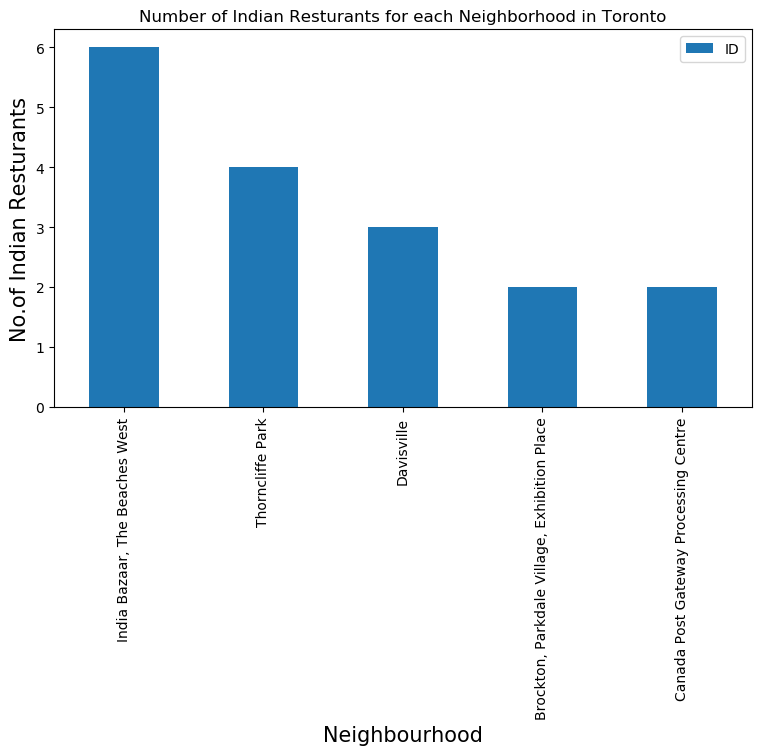

<Figure size 432x288 with 0 Axes>

In [143]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_Tr.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()

#displays the plot
plt.show()
plt.savefig('No_Of_Indian_Res_in_tr_NH.png') # save plot as image 

### Now we will get the ranking of each resturant for further analysis.

In [147]:
column_names=['Postcode','Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_Tr=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_Tr.values.tolist():
    
    Postcode, Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
   
    indian_rest_stats_Tr = indian_rest_stats_Tr.append({'Postcode':Postcode,
                                                'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4c632edeedd320a19ad5ae29
No data available for id= 4b7c3428f964a52047842fe3
No data available for id= 4c9fe5ca03133704df8d76d5


In [179]:
indian_rest_stats_Tr.head()


,Postcode,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",4af9a379f964a520c91222e3,Bombay Palace,14.0,7.2,13.0
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",52af6dc5498e33995b0bbf03,Sultan Of Samosas,9.0,6.8,4.0
2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16.0,8.1,19.0
3,M4E,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6.0,7.0,3.0
4,M1G,Scarborough,Woburn,0,0,0.0,0.0,0.0


Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [178]:
indian_rest_stats_Tr.to_csv('indian_rest_stats_Tr.csv', index=False)

Now lest check and clean our data

In [180]:
indian_rest_stats_Tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Postcode       45 non-null     object 
 1   Borough        45 non-null     object 
 2   Neighbourhood  45 non-null     object 
 3   ID             45 non-null     object 
 4   Name           45 non-null     object 
 5   Likes          45 non-null     float64
 6   Rating         45 non-null     float64
 7   Tips           45 non-null     float64
dtypes: float64(3), object(5)
memory usage: 2.9+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [151]:
indian_rest_stats_Tr['Likes']=indian_rest_stats_Tr['Likes'].astype('float64')
indian_rest_stats_Tr['Tips']=indian_rest_stats_Tr['Tips'].astype('float64')

In [226]:
indian_rest_stats_Tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Postcode       45 non-null     object 
 1   Borough        45 non-null     object 
 2   Neighbourhood  45 non-null     object 
 3   ID             45 non-null     object 
 4   Name           45 non-null     object 
 5   Likes          45 non-null     float64
 6   Rating         45 non-null     float64
 7   Tips           45 non-null     float64
dtypes: float64(3), object(5)
memory usage: 2.9+ KB


### Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

### Maximum Like

In [182]:
indian_rest_stats_Tr.iloc[indian_rest_stats_Tr['Likes'].idxmax()]

Postcode                              M6G
Borough                  Downtown Toronto
Neighbourhood                    Christie
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                                 142
Rating                                8.8
Tips                                   75
Name: 6, dtype: object

### Maximum Ratings

In [154]:
indian_rest_stats_Tr.iloc[indian_rest_stats_Tr['Rating'].idxmax()]

Postcode                              M6G
Borough                  Downtown Toronto
Neighbourhood                    Christie
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                                 142
Rating                                8.8
Tips                                   75
Name: 6, dtype: object

In [156]:
indian_rest_stats_Tr.iloc[indian_rest_stats_Tr['Tips'].idxmax()]

Postcode                              M6G
Borough                  Downtown Toronto
Neighbourhood                    Christie
ID               4adb969ef964a520332921e3
Name               Banjara Indian Cuisine
Likes                                 142
Rating                                8.8
Tips                                   75
Name: 6, dtype: object

### Lets find out top 5 Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

### Maximum Like

In [200]:
indian_rest_stats_Tr_LIKE=indian_rest_stats_Tr.sort_values(by=['Likes'],ascending=False)
indian_rest_stats_Tr_LIKE[['Borough','Name','Likes','Rating','Tips']].head()

,Borough,Name,Likes,Rating,Tips
6,Downtown Toronto,Banjara Indian Cuisine,142.0,8.8,75.0
19,East Toronto,Udupi Palace,79.0,8.4,31.0
17,West Toronto,Mother India,45.0,8.0,31.0
32,Central Toronto,Roti Cuisine of India,40.0,8.8,19.0
15,Downtown Toronto,Indian Roti House,38.0,7.1,14.0


### Maximum Ratings

In [201]:
indian_rest_stats_Tr_Rating=indian_rest_stats_Tr.sort_values(by=['Rating'],ascending=False)
indian_rest_stats_Tr_Rating[['Borough','Name','Likes','Rating','Tips']].head()

,Borough,Name,Likes,Rating,Tips
6,Downtown Toronto,Banjara Indian Cuisine,142.0,8.8,75.0
32,Central Toronto,Roti Cuisine of India,40.0,8.8,19.0
42,Downtown Toronto,Butter Chicken Factory,18.0,8.4,10.0
19,East Toronto,Udupi Palace,79.0,8.4,31.0
30,West Toronto,Curry Twist,20.0,8.3,17.0


### Maximum Tips

In [202]:
indian_rest_stats_Tr_Rating=indian_rest_stats_Tr.sort_values(by=['Tips'],ascending=False)
indian_rest_stats_Tr_Rating[['Borough','Name','Likes','Rating','Tips']].head()

,Borough,Name,Likes,Rating,Tips
6,Downtown Toronto,Banjara Indian Cuisine,142.0,8.8,75.0
17,West Toronto,Mother India,45.0,8.0,31.0
19,East Toronto,Udupi Palace,79.0,8.4,31.0
29,Scarborough,Karaikudi Chettinad South Indian Restaurant,27.0,6.5,23.0
7,Downtown Toronto,Madras Masala,35.0,7.9,21.0


### Next lets visualize neighborhood with maximum average rating of resturants.

In [195]:
Tr_neighbourhood_stats=indian_rest_stats_Tr.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
Tr_neighbourhood_stats.columns=['Borough','Average Rating']
Tr_neighbourhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
19,"St. James Town, Cabbagetown",8.40
5,Christie,8.35
11,"High Park, The Junction South",8.30
20,"The Annex, North Midtown, Yorkville",8.15
6,Church and Wellesley,8.10


Above are the top neighborhoods with top average rating of Indian resturants

### Similarly we will find the average rating of Indian Resturants for each Borough.

In [196]:
Tr_borough_stats=indian_rest_stats_Tr.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
Tr_borough_stats.columns=['Borough','Average Rating']
Tr_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Downtown Toronto,7.80
8,West Toronto,7.75
0,Central Toronto,7.66
4,Etobicoke,7.05
2,East Toronto,7.00


### Lets Visualize it.

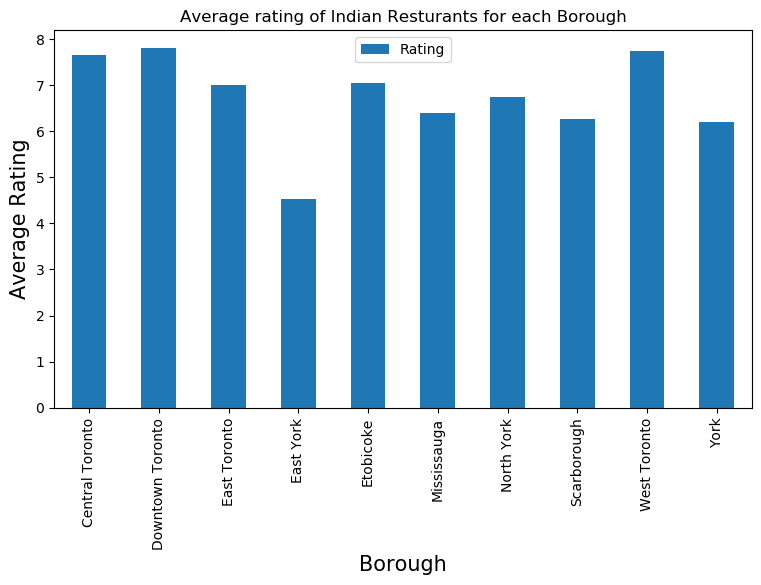

In [227]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_Tr.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.savefig('Avg_rating_in_BR.png') # save plot as image 
plt.show()


# Conclusion:

## So now we can answer the questions asked above in the Questions section of the notebook.

## From our anaysis the answers to the above questions are:

### 1. Which the major part of Toronto that has more Indian restaurant?  
###    Downtown Toronto and East Toronto has greater number of Indian restaurant
### 2. What is best location in Toronto for Indian cuisine?  
###    Downtown Toronto Higher number of average Rating i.e (7.80) followed by West Toronto  which has (7.75) average rating
### 3. Which area lacks Indian restaurant?   
###    York has less no. of Indian restaurant  